In [20]:
import pandas as pd

# Define base directory for the dataset
base_dir = "MobileWell400+/"

# Load survey-based data
daily_survey = pd.read_csv(base_dir + "daily_survey.csv", parse_dates=['timestamp'])
weekly_survey = pd.read_csv(base_dir + "weekly_survey.csv", parse_dates=['timestamp'])

# Load sensor-based data
light = pd.read_csv(base_dir + "light.csv", parse_dates=['timestamp'])
noise = pd.read_csv(base_dir + "noise.csv", parse_dates=['timestamp'])
screen = pd.read_csv(base_dir + "screen.csv", parse_dates=['timestamp'])



In [2]:
for name, df in {
    "daily_survey": daily_survey,
    "weekly_survey": weekly_survey,
    "light": light,
    "noise": noise,
    "screen": screen
}.items():
    print(f"{name:15} → shape: {df.shape}, columns: {list(df.columns)[:6]}")



daily_survey    → shape: (22563, 20), columns: ['participant', 'timestamp', 'valence', 'energetic_arousal', 'tense_arousal', 'emotional_event']
weekly_survey   → shape: (1074, 34), columns: ['participant', 'timestamp', 'health', 'physical_activity', 'TILS_1', 'TILS_2']
light           → shape: (1345973, 8), columns: ['participant', 'timestamp', 'max_lux', 'min_lux', 'std_lux', 'mean_lux']
noise           → shape: (239798, 8), columns: ['participant', 'timestamp', 'max_decibel', 'min_decibel', 'std_decibel', 'mean_decibel']
screen          → shape: (2133798, 4), columns: ['participant', 'timestamp', 'screen_event', 'timestamp_UTC']


In [24]:
def downsample_sensor(df, freq="5min"):
    """Aggregate sensor data to given frequency (default 5min) while keeping participant info."""
    if "participant" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df = (
            df.groupby("participant")
              .resample(freq, on="timestamp")
              .mean(numeric_only=True)
              .reset_index()
        )
    else:
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df = (
            df.set_index("timestamp")
              .resample(freq)
              .mean(numeric_only=True)
              .reset_index()
        )
    return df


In [25]:
# Downsample each sensor dataset
light_ds = downsample_sensor(light_clean)
noise_ds = downsample_sensor(noise_clean)
screen_ds = downsample_sensor(screen_clean)

# Merge on participant and timestamp
common_cols = ["participant", "timestamp"]

sensor_merged = (
    light_ds.merge(noise_ds, on=common_cols, how="outer", suffixes=("_light", "_noise"))
            .merge(screen_ds, on=common_cols, how="outer", suffixes=("", "_screen"))
)

sensor_merged = sensor_merged.sort_values(["participant", "timestamp"]).reset_index(drop=True)

# Add date column for easier merging later
sensor_merged["date"] = pd.to_datetime(sensor_merged["timestamp"]).dt.date

print(sensor_merged.columns)
print(sensor_merged.head())


C:\Users\Hp-\AppData\Local\Temp\ipykernel_5124\3981793147.py:6: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("participant")
C:\Users\Hp-\AppData\Local\Temp\ipykernel_5124\3981793147.py:6: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("participant")
C:\Users\Hp-\AppData\Local\Temp\ipykernel_5124\3981793147.py:6: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. Thi

Index(['participant', 'timestamp', 'max_lux', 'min_lux', 'std_lux', 'mean_lux',
       'num_samples_light', 'timestamp_UTC_light', 'max_decibel',
       'min_decibel', 'std_decibel', 'mean_decibel', 'num_samples_noise',
       'timestamp_UTC_noise', 'timestamp_UTC', 'date'],
      dtype='object')
  participant           timestamp  max_lux  min_lux    std_lux   mean_lux  \
0       AMdzA 2023-07-11 06:20:00      NaN      NaN        NaN        NaN   
1       AMdzA 2023-07-11 06:25:00      NaN      NaN        NaN        NaN   
2       AMdzA 2023-07-11 06:30:00      NaN      NaN        NaN        NaN   
3       AMdzA 2023-07-11 06:35:00      0.0      0.0   0.000000   0.000000   
4       AMdzA 2023-07-11 06:40:00     73.0      0.0  14.423165  53.842105   

   num_samples_light  timestamp_UTC_light  max_decibel  min_decibel  \
0                NaN                  NaN          NaN          NaN   
1                NaN                  NaN          NaN          NaN   
2                NaN      

In [ ]:
#  Merge daily survey data with sensor data 
# Ensure both have compatible date types
sensor_merged["date"] = pd.to_datetime(sensor_merged["date"])
daily_survey["date"] = pd.to_datetime(daily_survey["date"])

# Merge on participant and date
merged_df = pd.merge(
    sensor_merged,
    daily_survey[
        ["participant", "date", "valence", "energetic_arousal", "tense_arousal"]
    ],
    on=["participant", "date"],
    how="inner"
)

print("Merged shape:", merged_df.shape)
print(merged_df.head())


Merged shape: (6454027, 19)
  participant           timestamp  max_lux  min_lux  std_lux  mean_lux  \
0       AMdzA 2023-07-11 06:20:00      NaN      NaN      NaN       NaN   
1       AMdzA 2023-07-11 06:20:00      NaN      NaN      NaN       NaN   
2       AMdzA 2023-07-11 06:20:00      NaN      NaN      NaN       NaN   
3       AMdzA 2023-07-11 06:25:00      NaN      NaN      NaN       NaN   
4       AMdzA 2023-07-11 06:25:00      NaN      NaN      NaN       NaN   

   num_samples_light  timestamp_UTC_light  max_decibel  min_decibel  \
0                NaN                  NaN          NaN          NaN   
1                NaN                  NaN          NaN          NaN   
2                NaN                  NaN          NaN          NaN   
3                NaN                  NaN          NaN          NaN   
4                NaN                  NaN          NaN          NaN   

   std_decibel  mean_decibel  num_samples_noise  timestamp_UTC_noise  \
0          NaN           NaN

In [27]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# --- Select numeric features for Apriori ---
numeric_cols = merged_df.select_dtypes(include="number").columns

# --- Bin continuous numeric features ---
binned_df = merged_df.copy()
for col in numeric_cols:
    try:
        binned_df[col] = pd.qcut(binned_df[col], q=3, labels=["Low", "Med", "High"])
    except ValueError:
        # if not enough unique values for qcut
        binned_df[col] = pd.cut(binned_df[col], bins=3, labels=["Low", "Med", "High"])

# --- One-hot encode for Apriori ---
encoded_df = pd.get_dummies(binned_df[numeric_cols])

print("Encoded shape:", encoded_df.shape)


Encoded shape: (6454027, 48)


In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules


print("Initial shape:", df.shape)


df = df.dropna(subset=["InvoiceNo", "StockCode", "Description"])
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]  # remove cancellations

df["Description"] = df["Description"].str.strip().str.lower()


basket = (
    df.groupby(["InvoiceNo", "Description"])["Quantity"]
      .sum().unstack().fillna(0)
)

print("Basket shape before binarization:", basket.shape)


basket = (basket > 0).astype(int)  # True/False → 1/0
basket = basket.clip(0, 1)  # just in case of any rogue counts

item_sums = basket.sum(axis=0)
rare_items = item_sums[item_sums < len(basket)*0.02].index
basket = basket.drop(columns=rare_items, errors="ignore")

print("Basket shape after cleanup:", basket.shape)


frequent_itemsets = apriori(basket, min_support=0.03, use_colnames=True)
print("Frequent itemsets:", len(frequent_itemsets))

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values("lift", ascending=False)

print(rules.head(10))


Initial shape: (25000, 10)


KeyError: ['InvoiceNo', 'StockCode', 'Description']

In [ ]:
# DAILY AGGREGATES (participant × date)
import pandas as pd
import numpy as np


# ensure timestamps/dates are correct types
sensor_merged['date'] = pd.to_datetime(sensor_merged['date']).dt.date
daily_survey['date'] = pd.to_datetime(daily_survey['date']).dt.date

# Choose sensor columns that exist
sensor_cols = [c for c in ['mean_lux','std_lux','mean_decibel','std_decibel','num_samples_light','num_samples_noise'] if c in sensor_merged.columns]

# Aggregate: mean, median, max, std, count
agg_funcs = {}
for c in sensor_cols:
    agg_funcs[c] = ['mean','median','max','std','count']

daily_sensor = sensor_merged.groupby(['participant','date']).agg(agg_funcs)
# flatten columns
daily_sensor.columns = ['_'.join(col).strip() for col in daily_sensor.columns.values]
daily_sensor = daily_sensor.reset_index()

# If you have screen events (screen dataframe), compute fraction of 'SCREEN_ON' or 'UNLOCKED' per day
if 'screen' in globals():
    screen['date'] = pd.to_datetime(screen['timestamp']).dt.date
    screen_flags = screen.copy()
    screen_flags['is_on'] = screen_flags['screen_event'].str.contains('ON|UNLOCK', na=False)
    scr = screen_flags.groupby(['participant','date'])['is_on'].mean().reset_index().rename(columns={'is_on':'frac_screen_on'})
    daily_sensor = daily_sensor.merge(scr, on=['participant','date'], how='left')

# Merge with daily survey
df_daily = pd.merge(daily_sensor, daily_survey[['participant','date','valence','energetic_arousal','tense_arousal','emotional_event','social_quantity','social_quality']], on=['participant','date'], how='inner')

print("Daily dataset shape:", df_daily.shape)
df_daily.head()


Daily dataset shape: (22561, 39)


,participant,date,mean_lux_mean,mean_lux_median,mean_lux_max,mean_lux_std,mean_lux_count,std_lux_mean,std_lux_median,std_lux_max,...,num_samples_noise_max,num_samples_noise_std,num_samples_noise_count,frac_screen_on,valence,energetic_arousal,tense_arousal,emotional_event,social_quantity,social_quality
0,AMdzA,2023-07-11,107.304535,8.222222,806.529412,174.173908,168,19.932798,1.569680,439.500000,...,NaN,NaN,0,0.624521,20,73,37,3.0,3-5 persons,13.0
1,AMdzA,2023-07-11,107.304535,8.222222,806.529412,174.173908,168,19.932798,1.569680,439.500000,...,NaN,NaN,0,0.624521,14,39,40,12.0,no,NaN
2,AMdzA,2023-07-11,107.304535,8.222222,806.529412,174.173908,168,19.932798,1.569680,439.500000,...,NaN,NaN,0,0.624521,-7,30,63,NaN,no,NaN
3,AMdzA,2023-07-12,1498.004217,12.916667,113976.153846,10106.402664,173,97.137177,1.472538,7970.135103,...,11.0,2.12132,2,0.621908,-22,25,83,-36.0,1 person,-10.0
4,AMdzA,2023-07-12,1498.004217,12.916667,113976.153846,10106.402664,173,97.137177,1.472538,7970.135103,...,11.0,2.12132,2,0.621908,-17,34,77,-23.0,1 person,NaN


In [ ]:
# PAIRWISE SENSOR -> SURVEY SCORES 
from scipy import stats

work = df_daily.copy()



work['mean_lux_high'] = (work['mean_lux_mean'] > work['mean_lux_mean'].quantile(0.66)).astype(int) if 'mean_lux_mean' in work.columns else 0
work['mean_decibel_high'] = (work['mean_decibel_mean'] > work['mean_decibel_mean'].quantile(0.66)).astype(int) if 'mean_decibel_mean' in work.columns else 0
if 'frac_screen_on' in work.columns:
    work['frac_screen_on_high'] = (work['frac_screen_on'] > work['frac_screen_on'].quantile(0.66)).astype(int)

# Bin valence into Low/Med/High for quick checks
work['valence_bin'] = pd.qcut(work['valence'], q=3, labels=['Low','Med','High'])

# build sensor flags and survey flags
sensor_flags = ['mean_lux_high','mean_decibel_high']
if 'frac_screen_on_high' in work.columns: sensor_flags.append('frac_screen_on_high')

survey_flags = ['valence_bin']  # we will check the High bin specifically
N = len(work)

rows = []
for s in sensor_flags:
    if s not in work.columns: continue
    for sv in ['valence_bin']:
        # focus on High
        mask_s = work[s] == 1
        mask_t = work[sv] == 'High'
        both = (mask_s & mask_t).sum()
        if both == 0: continue
        support = both / N
        confidence = both / mask_s.sum() if mask_s.sum()>0 else 0
        target_support = mask_t.sum() / N
        lift = confidence / target_support if target_support>0 else np.nan
        rows.append({'sensor':s,'survey':sv+'=High','support':support,'confidence':confidence,'lift':lift,
                     'ante_count':int(mask_s.sum()),'conseq_count':int(mask_t.sum())})
res = pd.DataFrame(rows).sort_values(['lift','confidence'], ascending=False).reset_index(drop=True)
res


,sensor,survey,support,confidence,lift,ante_count,conseq_count
0,mean_decibel_high,valence_bin=High,0.066752,0.360891,1.121652,4173,7259
1,mean_lux_high,valence_bin=High,0.103940,0.335239,1.041926,6995,7259
2,frac_screen_on_high,valence_bin=High,0.108506,0.319582,0.993263,7660,7259


In [ ]:
#  QUICK SUPERVISED: predict valence_high via logistic regression + permutation importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance

# prepare dataset: binary target valence_high
work2 = work.copy()  # from previous block
work2['valence_high'] = (work2['valence'] > work2['valence'].quantile(0.66)).astype(int)

# features: numeric aggregates plus the binary flags created earlier
feat_cols = []
for c in ['mean_lux_mean','mean_decibel_mean','std_lux_mean','std_decibel_mean','frac_screen_on']:
    if c in work2.columns:
        feat_cols.append(c)
feat_cols += [f for f in ['mean_lux_high','mean_decibel_high','frac_screen_on_high'] if f in work2.columns]

X = work2[feat_cols].fillna(0)
y = work2['valence_high']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:,1]
print("AUC:", roc_auc_score(y_test, pred))
print("Accuracy:", accuracy_score(y_test, (pred>0.5).astype(int)))

# Permutation importance for interpretability
imp = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42)
imp_df = pd.DataFrame({'feature': X.columns, 'importance_mean': imp.importances_mean}).sort_values('importance_mean', ascending=False)
imp_df


AUC: 0.505582814433611
Accuracy: 0.6606984577202624


,feature,importance_mean
2,std_lux_mean,0.000821
0,mean_lux_mean,0.000355
7,frac_screen_on_high,0.000053
3,std_decibel_mean,0.000006
1,mean_decibel_mean,0.000000
4,frac_screen_on,0.000000
5,mean_lux_high,0.000000
6,mean_decibel_high,0.000000


ASSOCIATION RULES AND RELATIONS BETWEEN SENSOR DATA AND SURVEY DATA

In [61]:
# SENSOR -> SURVEY pairwise scan for ALL survey variables
import pandas as pd, numpy as np

# ---------- Prepare daily dataframe ----------
# prefer df_daily if you already made it; else build a simple one from sensor_merged + daily_survey
if 'df_daily' in globals():
    daily = df_daily.copy()
else:
    # aggregate sensor_merged to participant x date (safe fallback)
    sm = sensor_merged.copy()
    if 'date' not in sm.columns:
        sm['date'] = pd.to_datetime(sm['timestamp']).dt.date
    if 'date' in daily_survey.columns:
        daily_survey['date'] = pd.to_datetime(daily_survey['date']).dt.date
    # choose a few numeric sensor columns if present
    sensor_cols_agg = [c for c in ['mean_lux','mean_decibel','num_samples_light','num_samples_noise'] if c in sm.columns]
    if sensor_cols_agg:
        agg = sm.groupby(['participant','date'])[sensor_cols_agg].agg(['mean','median','std'])
        agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
        agg = agg.reset_index()
        daily = pd.merge(agg, daily_survey, on=['participant','date'], how='inner')
    else:
        # fallback: if sensor_merged already has participant+date+mean features
        cols = [c for c in sensor_merged.columns if c in ['participant','date','mean_lux','mean_decibel','num_samples_light','num_samples_noise']]
        daily = pd.merge(sensor_merged[cols], daily_survey, on=['participant','date'], how='inner')

print("Daily shape:", daily.shape)

# ---------- define survey targets to test ----------
survey_targets = [c for c in ['valence','energetic_arousal','tense_arousal','emotional_event','social_quantity','social_quality','occasion'] if c in daily.columns]
print("Survey targets tested:", survey_targets)

# ---------- define sensor features to use (basic set) ----------
# prefer aggregated numeric(sensor)_mean columns if available, else num_samples_*
sensor_candidates = []
for pref in ['mean_lux_mean','mean_lux','mean_decibel_mean','mean_decibel','num_samples_light','num_samples_noise','frac_screen_on']:
    if pref in daily.columns:
        sensor_candidates.append(pref)
# If none found, try raw num_samples
if not sensor_candidates:
    for c in ['num_samples_light','num_samples_noise','mean_lux','mean_decibel']:
        if c in daily.columns:
            sensor_candidates.append(c)
print("Sensor features used:", sensor_candidates)

# ---------- create sensor boolean flags ----------
sensor_flags = {}
for c in sensor_candidates:
    if pd.api.types.is_numeric_dtype(daily[c]):
        # use median split and 66% for high-lift signals (you can change)
        med = daily[c].median()
        sensor_flags[f"{c}=High"] = daily[c] > med
        sensor_flags[f"{c}=Low"]  = daily[c] <= med
    else:
        # categorical: keep top 3 values
        vals = daily[c].value_counts().nlargest(3).index
        for v in vals:
            sensor_flags[f"{c}={v}"] = daily[c] == v

# ---------- function to compute pairwise metrics ----------
def compute_pairs(sensor_flags, daily, target_col, pos_label='High', top_n=10):
    n = len(daily)
    results = []
    # make target-high mask
    if pd.api.types.is_numeric_dtype(daily[target_col]):
        q_hi = daily[target_col].quantile(0.66)
        target_mask = daily[target_col] > q_hi
        target_name = f"{target_col}={pos_label}"
    else:
        # categorical target: choose the most common value if pos_label not applicable
        vals = daily[target_col].value_counts().nlargest(3).index
        # default check for first value
        target_mask = daily[target_col] == vals[0]
        target_name = f"{target_col}={vals[0]}"
    target_support = target_mask.sum() / n if n>0 else 0

    for sk, smask in sensor_flags.items():
        s_count = smask.sum()
        if s_count == 0:
            continue
        both = (smask & target_mask).sum()
        if both == 0:
            continue
        support = both / n
        confidence = both / s_count
        lift = confidence / target_support if target_support>0 else np.nan
        results.append({
            'sensor': sk, 'survey_target': target_name,
            'support': support, 'confidence': confidence, 'lift': lift,
            'ante_count': int(s_count), 'target_count': int(target_mask.sum())
        })
    res = pd.DataFrame(results)
    if res.empty:
        return res
    return res.sort_values(['lift','confidence','support'], ascending=[False,False,False]).head(top_n)

# ---------- run for each survey variable ----------
all_results = {}
for tgt in survey_targets:
    top = compute_pairs(sensor_flags, daily, tgt, pos_label='High', top_n=20)
    all_results[tgt] = top
    print("\nTop pairs for target:", tgt)
    if top.empty:
        print("  (no co-occurrences found for top bins — try lowering thresholds or changing binning)")
    else:
        display(top)

# If you want a combined table:
combined = pd.concat([all_results[t].assign(target=t) for t in all_results if not all_results[t].empty], ignore_index=True)
print("\nCombined top pairs (first 50 rows):")
display(combined.head(50))


Daily shape: (22561, 39)
Survey targets tested: ['valence', 'energetic_arousal', 'tense_arousal', 'emotional_event', 'social_quantity', 'social_quality']
Sensor features used: ['mean_lux_mean', 'mean_decibel_mean', 'frac_screen_on']

Top pairs for target: valence


,sensor,survey_target,support,confidence,lift,ante_count,target_count
2,mean_decibel_mean=High,valence=High,0.095209,0.350122,1.031484,6135,7658
1,mean_lux_mean=Low,valence=High,0.158415,0.347395,1.023450,10288,7658
0,mean_lux_mean=High,valence=High,0.158371,0.347365,1.023362,10286,7658
4,frac_screen_on=High,valence=High,0.172909,0.346171,1.019844,11269,7658
5,frac_screen_on=Low,valence=High,0.166127,0.332417,0.979323,11275,7658
3,mean_decibel_mean=Low,valence=High,0.088117,0.323831,0.954029,6139,7658



Top pairs for target: energetic_arousal


,sensor,survey_target,support,confidence,lift,ante_count,target_count
0,mean_lux_mean=High,energetic_arousal=High,0.158681,0.348046,1.048226,10286,7491
5,frac_screen_on=Low,energetic_arousal=High,0.168698,0.337561,1.016648,11275,7491
1,mean_lux_mean=Low,energetic_arousal=High,0.152165,0.333690,1.004989,10288,7491
2,mean_decibel_mean=High,energetic_arousal=High,0.089358,0.328606,0.989679,6135,7491
4,frac_screen_on=High,energetic_arousal=High,0.162892,0.326116,0.982179,11269,7491
3,mean_decibel_mean=Low,energetic_arousal=High,0.083551,0.307053,0.924767,6139,7491



Top pairs for target: tense_arousal


,sensor,survey_target,support,confidence,lift,ante_count,target_count
2,mean_decibel_mean=High,tense_arousal=High,0.097159,0.357294,1.072501,6135,7516
5,frac_screen_on=Low,tense_arousal=High,0.168078,0.336319,1.009540,11275,7516
0,mean_lux_mean=High,tense_arousal=High,0.152830,0.335213,1.006219,10286,7516
3,mean_decibel_mean=Low,tense_arousal=High,0.090510,0.332627,0.998458,6139,7516
4,frac_screen_on=High,tense_arousal=High,0.164886,0.330109,0.990898,11269,7516
1,mean_lux_mean=Low,tense_arousal=High,0.147733,0.323970,0.972469,10288,7516



Top pairs for target: emotional_event


,sensor,survey_target,support,confidence,lift,ante_count,target_count
0,mean_lux_mean=High,emotional_event=High,0.099286,0.217772,1.063913,10286,4618
4,frac_screen_on=High,emotional_event=High,0.106556,0.213329,1.042206,11269,4618
2,mean_decibel_mean=High,emotional_event=High,0.056203,0.206683,1.009739,6135,4618
3,mean_decibel_mean=Low,emotional_event=High,0.053366,0.196123,0.958149,6139,4618
5,frac_screen_on=Low,emotional_event=High,0.097912,0.195920,0.957158,11275,4618
1,mean_lux_mean=Low,emotional_event=High,0.089180,0.195568,0.955436,10288,4618



Top pairs for target: social_quantity


,sensor,survey_target,support,confidence,lift,ante_count,target_count
5,frac_screen_on=Low,social_quantity=3-5 persons,0.142503,0.285144,1.054613,11275,6100
0,mean_lux_mean=High,social_quantity=3-5 persons,0.129383,0.283784,1.049581,10286,6100
3,mean_decibel_mean=Low,social_quantity=3-5 persons,0.072913,0.267959,0.991053,6139,6100
1,mean_lux_mean=Low,social_quantity=3-5 persons,0.116750,0.256026,0.946920,10288,6100
4,frac_screen_on=High,social_quantity=3-5 persons,0.127654,0.255568,0.945226,11269,6100
2,mean_decibel_mean=High,social_quantity=3-5 persons,0.068570,0.252160,0.932619,6135,6100



Top pairs for target: social_quality


,sensor,survey_target,support,confidence,lift,ante_count,target_count
4,frac_screen_on=High,social_quality=High,0.136829,0.273937,1.048041,11269,5897
2,mean_decibel_mean=High,social_quality=High,0.073002,0.268460,1.027085,6135,5897
1,mean_lux_mean=Low,social_quality=High,0.120739,0.264774,1.012986,10288,5897
0,mean_lux_mean=High,social_quality=High,0.119144,0.261326,0.999793,10286,5897
3,mean_decibel_mean=Low,social_quality=High,0.070697,0.259814,0.994009,6139,5897
5,frac_screen_on=Low,social_quality=High,0.124418,0.248958,0.952474,11275,5897



Combined top pairs (first 50 rows):


,sensor,survey_target,support,confidence,lift,ante_count,target_count,target
0,mean_decibel_mean=High,valence=High,0.095209,0.350122,1.031484,6135,7658,valence
1,mean_lux_mean=Low,valence=High,0.158415,0.347395,1.023450,10288,7658,valence
2,mean_lux_mean=High,valence=High,0.158371,0.347365,1.023362,10286,7658,valence
3,frac_screen_on=High,valence=High,0.172909,0.346171,1.019844,11269,7658,valence
4,frac_screen_on=Low,valence=High,0.166127,0.332417,0.979323,11275,7658,valence
5,mean_decibel_mean=Low,valence=High,0.088117,0.323831,0.954029,6139,7658,valence
6,mean_lux_mean=High,energetic_arousal=High,0.158681,0.348046,1.048226,10286,7491,energetic_arousal
7,frac_screen_on=Low,energetic_arousal=High,0.168698,0.337561,1.016648,11275,7491,energetic_arousal
8,mean_lux_mean=Low,energetic_arousal=High,0.152165,0.333690,1.004989,10288,7491,energetic_arousal
9,mean_decibel_mean=High,energetic_arousal=High,0.089358,0.328606,0.989679,6135,7491,energetic_arousal


CORRELATION BETWEEN Social Parameters and Lifestyle Paramaeters

In [67]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from itertools import combinations
from math import sqrt

# ---- 1. Make sure binned DataFrame is available ----
# (Assumes you already have "binned" or "df" containing survey columns like valence, etc.)
# Replace 'binned' with your actual DataFrame if named differently
assert 'valence' in binned.columns, "Expected survey columns missing."

# ---- 2. Clean social_quantity ----
import re

def parse_social_qty(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ('nan','none','no one','noone','0','0 persons','0 people','missing'):
        return 0.0
    if re.fullmatch(r'\d+', s):
        return float(int(s))
    if 'person' in s or 'people' in s or 'persons' in s:
        nums = re.findall(r'\d+', s)
        if nums:
            return float(np.mean(list(map(int, nums))))
    rng = re.findall(r'(\d+)\s*-\s*(\d+)', s)
    if rng:
        a, b = map(int, rng[0])
        return (a + b) / 2.0
    rng2 = re.findall(r'(\d+)\s*(?:to|and)\s*(\d+)', s)
    if rng2:
        a, b = map(int, rng2[0])
        return (a + b) / 2.0
    m2 = re.search(r'(\d+)\s*\+', s)
    if m2:
        return float(int(m2.group(1)))
    m3 = re.search(r'more than\s*(\d+)', s)
    if m3:
        return float(int(m3.group(1))) + 1.0
    nums = re.findall(r'\d+', s)
    if nums:
        return float(sum(map(int, nums)) / len(nums))
    return np.nan

binned['social_quantity_num'] = binned['social_quantity'].apply(parse_social_qty)

print("Parsed social_quantity -> numeric values summary:")
print(binned['social_quantity_num'].describe())

# ---- 3. Create quartiles for social_quantity ----
if binned['social_quantity_num'].notna().sum() >= 3:
    try:
        binned['social_qty_q'] = pd.qcut(
            binned['social_quantity_num'].fillna(binned['social_quantity_num'].median()),
            q=4, labels=['Q1','Q2','Q3','Q4'], duplicates='drop'
        )
    except Exception as e:
        print("qcut failed, using median split instead:", e)
        med = binned['social_quantity_num'].median()
        binned['social_qty_q'] = np.where(binned['social_quantity_num'] > med, 'High', 'Low')
else:
    binned['social_qty_q'] = binned['social_quantity'].astype(str).fillna('Missing')

print("\nSocial Quantity Bins:")
print(binned['social_qty_q'].value_counts(dropna=False))


# ---- 4. Select relevant variables ----
targets = ['valence', 'emotional_event', 'tense_arousal', 'energetic_arousal']
social_vars = ['social_quantity_num', 'social_quality', 'social_qty_q']

print("\n=== Correlations: numeric social_quantity vs emotional targets ===")
corrs = binned[['social_quantity_num'] + targets].corr(numeric_only=True)
print(corrs['social_quantity_num'].drop('social_quantity_num'))


# ---- 5. Compare mean target values across social quartiles ----
if 'social_qty_q' in binned.columns:
    print("\n=== Means of targets by social_quantity quartiles ===")
    print(binned.groupby('social_qty_q')[targets].agg(['mean','count']))


# ---- 6. OLS regressions: each target ~ social_quantity_num ----
print("\n=== Simple OLS regressions (each target ~ social_quantity_num) ===")
for t in targets:
    try:
        model = smf.ols(f"{t} ~ social_quantity_num", data=binned).fit()
        coef = model.params.get('social_quantity_num', np.nan)
        pval = model.pvalues.get('social_quantity_num', np.nan)
        print(f"{t:<20}: coef={coef:.3f}, p={pval:.4f}, R²={model.rsquared:.3f}")
    except Exception as e:
        print(f"{t:<20}: error - {e}")


# ---- 7. If social_quality is categorical, compare group means ----
if 'social_quality' in binned.columns:
    print("\n=== Means by social_quality category ===")
    print(binned.groupby('social_quality')[targets].agg(['mean','count']))

print("\nDone.")


Parsed social_quantity -> numeric values summary:
count    19926.000000
mean         3.316872
std          1.534501
min          1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: social_quantity_num, dtype: float64
qcut failed, using median split instead: Bin labels must be one fewer than the number of bin edges

Social Quantity Bins:
social_qty_q
Low     16635
High     5926
Name: count, dtype: int64

=== Correlations: numeric social_quantity vs emotional targets ===
valence              0.058669
emotional_event      0.029353
tense_arousal       -0.032023
energetic_arousal   -0.009840
Name: social_quantity_num, dtype: float64

=== Means of targets by social_quantity quartiles ===
                valence        emotional_event        tense_arousal         \
                   mean  count            mean  count          mean  count   
social_qty_q                                                                 
High          23.521093 

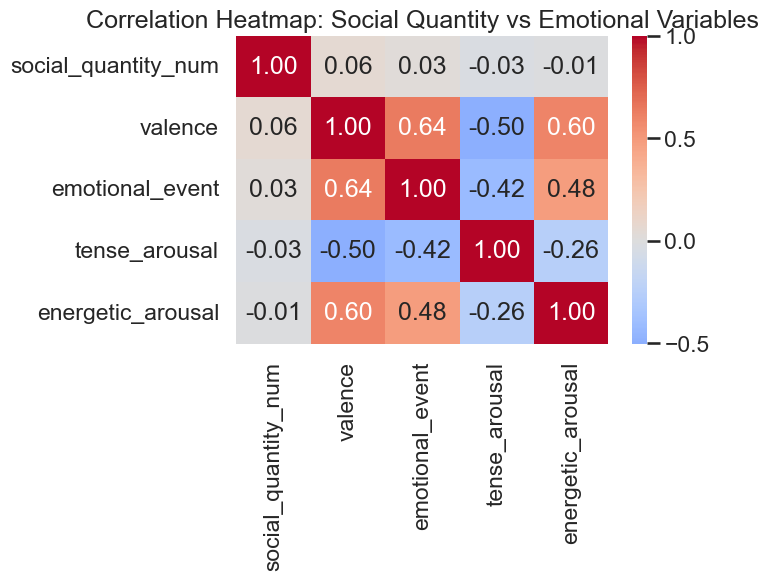

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a clean style
sns.set(style="whitegrid", context="talk")

# --- 1. Correlation heatmap ---
plt.figure(figsize=(6, 4))
corr_matrix = binned[['social_quantity_num', 'valence', 'emotional_event', 'tense_arousal', 'energetic_arousal']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Heatmap: Social Quantity vs Emotional Variables")
plt.show()

